Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\jdejo\Downloads\healthcare_dataset\healthcare_dataset.csv")


Exploratory Data Analysis and Preparation

In [2]:
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

In [4]:
df['Blood Type'].value_counts()

Blood Type
A-     6969
A+     6956
AB+    6947
AB-    6945
B+     6945
B-     6944
O+     6917
O-     6877
Name: count, dtype: int64

<Axes: >

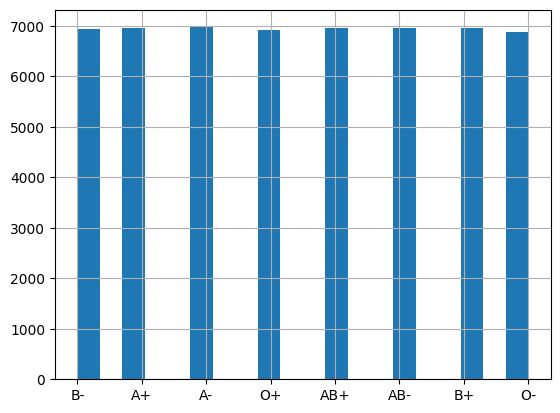

In [5]:
df['Blood Type'].hist(bins=20)

<Axes: >

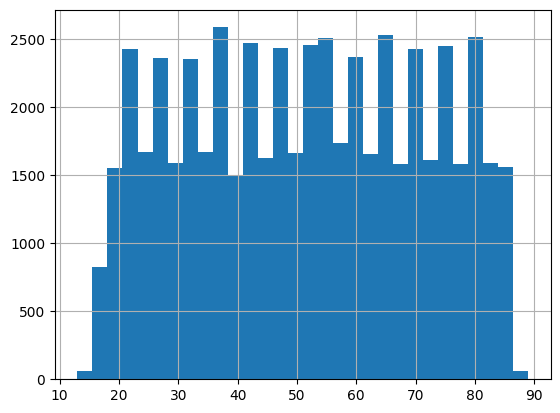

In [6]:
df['Age'].hist(bins=30)

In [7]:
df['Gender'].value_counts()

Gender
Male      27774
Female    27726
Name: count, dtype: int64

<Axes: xlabel='Gender'>

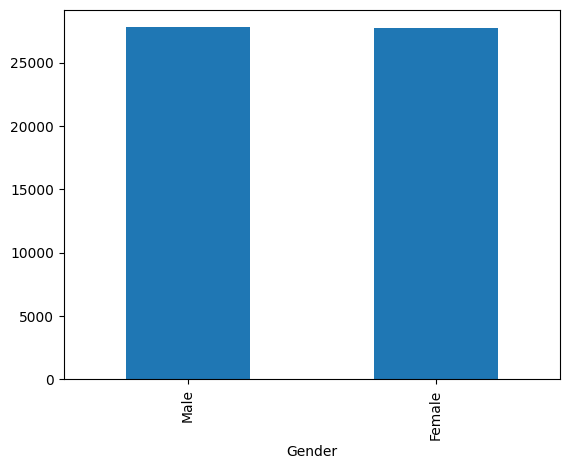

In [8]:
df['Gender'].value_counts().plot(kind='bar')

In [9]:
df['Medical Condition'].value_counts()

Medical Condition
Arthritis       9308
Diabetes        9304
Hypertension    9245
Obesity         9231
Cancer          9227
Asthma          9185
Name: count, dtype: int64

<Axes: >

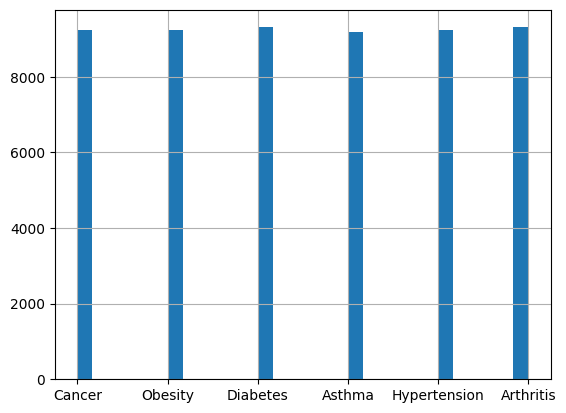

In [10]:
df['Medical Condition'].hist(bins=30)

<Axes: >

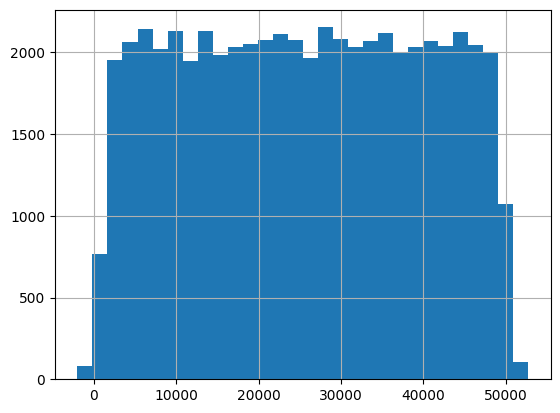

In [11]:
df['Billing Amount'].hist(bins=30)

In [12]:
df['Insurance Provider'].value_counts()

Insurance Provider
Cigna               11249
Medicare            11154
UnitedHealthcare    11125
Blue Cross          11059
Aetna               10913
Name: count, dtype: int64

<Axes: >

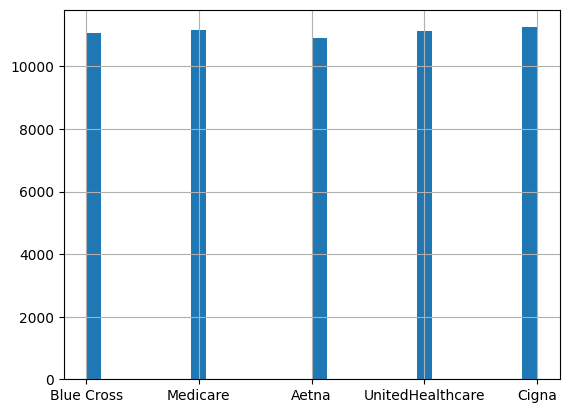

In [13]:
df['Insurance Provider'].hist(bins=30)

In [14]:
df['Admission Type'].value_counts()

Admission Type
Elective     18655
Urgent       18576
Emergency    18269
Name: count, dtype: int64

<Axes: >

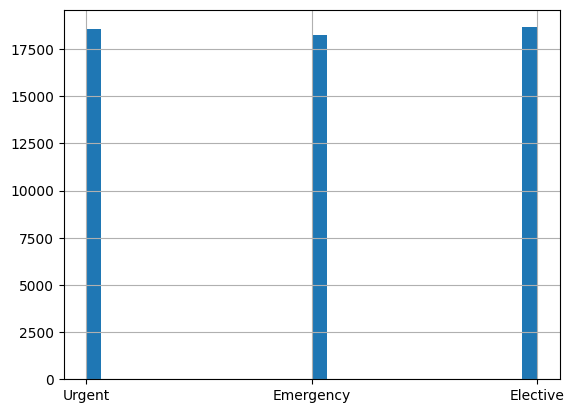

In [15]:
df['Admission Type'].hist(bins=30)

In [16]:
df['Medication'].value_counts()

Medication
Lipitor        11140
Ibuprofen      11127
Aspirin        11094
Paracetamol    11071
Penicillin     11068
Name: count, dtype: int64

<Axes: >

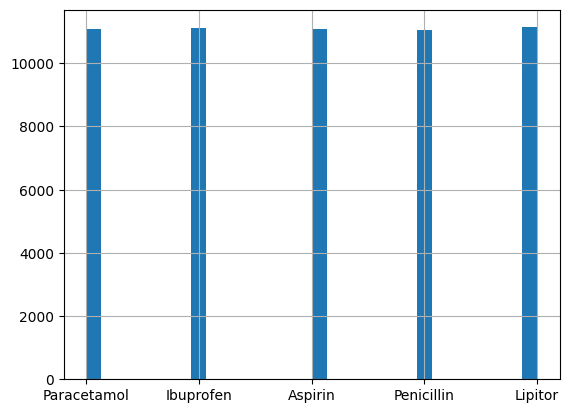

In [17]:
df['Medication'].hist(bins=30)

In [18]:
df['Test Results'].value_counts()

Test Results
Abnormal        18627
Normal          18517
Inconclusive    18356
Name: count, dtype: int64

<Axes: >

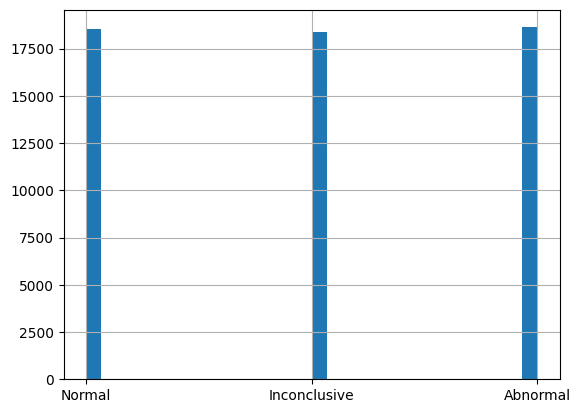

In [19]:
df['Test Results'].hist(bins=30)

In [20]:
import time
from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


# -------------------- Config --------------------
TARGET_COL = "Test Results"
DROP_COLS = ['Name','Doctor','Hospital','Room Number','Discharge Date','Date of Admission']

GLOBAL_SAMPLE_N = None#10_000          # global training+test sample for quick runs
TEST_SIZE = 0.25
RANDOM_STATE = 42

# Per-model caps for expensive models. Set to None to remove the cap later.
# PER_MODEL_CAP = {
#     "SVC_RBF": 4_000,
#     "KNN_15": 6_000,
#     "XGBoost": 8_000,   # ignored if xgboost missing
# }

PER_MODEL_CAP = {
    "SVC_RBF": None,
    "KNN_15": None,
    "XGBoost": None,
}

# -------------------- Load + prepare --------------------
df = pd.read_csv(r"C:\Users\jdejo\Downloads\healthcare_dataset\healthcare_dataset.csv")
use_cols = [c for c in df.columns if c not in DROP_COLS]
df = df[use_cols].copy()

# sample globally for speed
if GLOBAL_SAMPLE_N and GLOBAL_SAMPLE_N < len(df):
    df = df.sample(GLOBAL_SAMPLE_N, random_state=RANDOM_STATE).reset_index(drop=True)

# y = df[TARGET_COL].astype("category")
y = df[TARGET_COL]
# Create and fit label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = pd.Categorical(y_encoded)  # Convert to categorical for consistency
X = df.drop(columns=[TARGET_COL])
joblib.dump(label_encoder, "./artifacts/label_encoder.joblib")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, stratify=y_encoded, random_state=RANDOM_STATE
)#Was using y, but now using y_encoded

def maybe_cap(Xa, ya, cap, label):
    if cap is None or cap >= len(Xa):
        return Xa, ya
    # stratified downsample
    tmp = Xa.assign(__y__=ya.values)
    Xa_small = (tmp.groupby("__y__", group_keys=False)
                  .apply(lambda g: g.sample(max(1, int(len(g)*cap/len(tmp))), random_state=RANDOM_STATE))
                  .sample(frac=1.0, random_state=RANDOM_STATE))
    ya_small = Xa_small["__y__"].astype(ya.dtype)
    Xa_small = Xa_small.drop(columns=["__y__"])
    return Xa_small, ya_small

# -------------------- Models --------------------
models = {
    "LogReg": LogisticRegression(max_iter=800, solver="saga", multi_class="multinomial",
                                 n_jobs=-1, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=RANDOM_STATE),
    "HistGB": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN_15": KNeighborsClassifier(n_neighbors=15, weights="distance"),
    "SVC_RBF": SVC(C=2.0, kernel="rbf", gamma="scale", probability=False, random_state=RANDOM_STATE),
    "XGBoost": None
}


# -------------------- Fit + evaluate --------------------
rows = []
reports = {}
fitted = {}

for name, clf in models.items():
    
    if name == "XGBoost":
        clf = XGBClassifier(
            n_estimators=300, learning_rate=0.1, max_depth=6, subsample=0.9, 
            colsample_bytree=0.9, reg_lambda=1.0, tree_method="hist", 
            random_state=RANDOM_STATE, n_jobs=-1
        )
    
    Xtr, ytr = X_train, y_train
    cap = PER_MODEL_CAP.get(name)
    if cap:  # cap heavy models
        Xtr, ytr = maybe_cap(Xtr, ytr, cap, name)

    pipe = Pipeline([("pre", pre), ("clf", clf)])
    t0 = time.time()
    pipe.fit(Xtr, ytr)
    train_sec = time.time() - t0

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    bal = balanced_accuracy_score(y_test, y_pred)

    rows.append({
        "model": name,
        "train_samples": len(ytr),
        "train_time_s": round(train_sec, 2),
        "test_accuracy": acc,
        "test_f1_macro": f1m,
        "test_bal_acc": bal
    })
    reports[name] = classification_report(y_test, y_pred, digits=4)
    fitted[name] = pipe

results = pd.DataFrame(rows).sort_values("test_f1_macro", ascending=False).reset_index(drop=True)
print(results)


c:\Users\jdejo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


          model  train_samples  train_time_s  test_accuracy  test_f1_macro  \
0  RandomForest          41625          3.69       0.424793       0.424755   
1        KNN_15          41625          0.12       0.422991       0.422977   
2  DecisionTree          41625          0.81       0.398559       0.398553   
3       XGBoost          41625          4.29       0.371892       0.371755   
4       SVC_RBF          41625        355.44       0.357550       0.356991   
5        LogReg          41625          7.61       0.339027       0.335127   
6        HistGB          41625          0.96       0.338378       0.324791   

   test_bal_acc  
0      0.424759  
1      0.422975  
2      0.398590  
3      0.371854  
4      0.357391  
5      0.338607  
6      0.337606  


<BarContainer object of 7 artists>

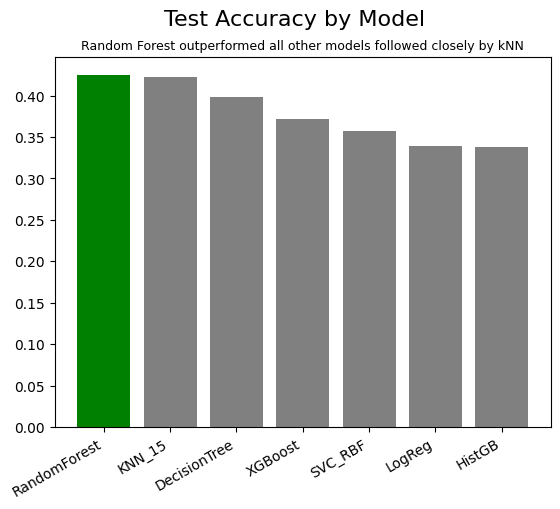

In [21]:
colors = ['green' if _ == results.test_accuracy.max() else 'gray' for _ in results.test_accuracy]
import matplotlib.pyplot as plt
plt.title("Random Forest outperformed all other models followed closely by kNN", fontsize=9)
plt.suptitle("Test Accuracy by Model", fontsize=16)
plt.xticks(rotation=30, ha="right")
plt.bar(results.model, results.test_accuracy, color=colors)

In [22]:
best_name = results.loc[0, "model"]
print("\nBest model:", best_name)
print("\nClassification report (best):\n")
print(reports[best_name])

# Save artifacts
out_dir = Path("./artifacts")
out_dir.mkdir(parents=True, exist_ok=True)
results.to_csv(out_dir/"model_holdout_results.csv", index=False)

try:
    import joblib
    joblib.dump(fitted[best_name], out_dir/f"best_model_{best_name}.joblib")
except Exception:
    pass


Best model: RandomForest

Classification report (best):

              precision    recall  f1-score   support

           0     0.4251    0.4286    0.4269      4657
           1     0.4188    0.4156    0.4171      4589
           2     0.4304    0.4301    0.4303      4629

    accuracy                         0.4248     13875
   macro avg     0.4248    0.4248    0.4248     13875
weighted avg     0.4248    0.4248    0.4248     13875



In [23]:
import random

# Paths
DATA_PATH = r"C:\Users\jdejo\Downloads\healthcare_dataset\healthcare_dataset.csv"
MODEL_PATH = "./artifacts/best_model_RandomForest.joblib"

# Load model
rf_pipe = joblib.load(MODEL_PATH)

# Load dataset (same preprocessing assumptions as training)
df = pd.read_csv(DATA_PATH)
DROP_COLS = ['Name','Doctor','Hospital','Room Number','Discharge Date','Date of Admission']
use_cols = [c for c in df.columns if c not in DROP_COLS]
df = df[use_cols].copy()

# Choose a random row
row_idx = random.randrange(len(df))
row = df.iloc[[row_idx]]  # keep DataFrame shape

# True label
true_label = row["Test Results"].values[0]

#Load label encoder
label_encoder = joblib.load("./artifacts/label_encoder.joblib")

# Predict (drop target col from features)
X_row = row.drop(columns=["Test Results"])
pred_label = rf_pipe.predict(X_row)[0]
proba = None
if hasattr(rf_pipe.named_steps["clf"], "predict_proba"):
    proba = rf_pipe.predict_proba(X_row)[0]

print("\n" + "="*60)
print("RANDOM ROW PREDICTION")
print("="*60)

print("\nPatient Features:")
for col in row.columns:
    if col != TARGET_COL:
        print(f"  {col}: {row[col].iloc[0]}")
print(f"Random row index: {row_idx}")
print("True label:", true_label)
print("Predicted label:", label_encoder.classes_[pred_label])
if proba is not None:
    print("Class probabilities:", dict(zip(rf_pipe.named_steps['clf'].classes_, proba)))



RANDOM ROW PREDICTION

Patient Features:
  Age: 33
  Gender: Female
  Blood Type: B-
  Medical Condition: Arthritis
  Insurance Provider: Aetna
  Billing Amount: 36899.54111307147
  Admission Type: Emergency
  Medication: Paracetamol
Random row index: 43345
True label: Normal
Predicted label: Normal
Class probabilities: {np.int64(0): np.float64(0.16), np.int64(1): np.float64(0.28), np.int64(2): np.float64(0.56)}
